In [1]:
import os, calendar, pickle
import climate_indices as ci, xarray as xr, numpy as np
import pandas as pd, cartopy.crs as ccrs, matplotlib.colors as colors
from pathlib import Path
from climate_indices import indices, compute
from datetime import date
from matplotlib import pyplot as plt
from cartopy import feature as cf 

def to_pickle(name, dataset, directory):
    extension = '.pkl'
    newpath = f'{directory}/{name}{extension}'
    with open(newpath, 'wb') as f:
        pickle.dump(dataset, f)
        print(f'Pickled "{name}" @ {newpath}')
    return newpath

class MyCustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "__main__":
            module = "program"
        return super().find_class(module, name)
    
def open_pickle(filepath):
    with open(filepath, 'rb') as f: 
        unpickler = MyCustomUnpickler(f)
        return unpickler.load()
    
help(indices)

Help on module climate_indices.indices in climate_indices:

NAME
    climate_indices.indices

FUNCTIONS
    pdsi(precip_time_series: numpy.ndarray, pet_time_series: numpy.ndarray, awc: float, data_start_year: int, calibration_start_year: int, calibration_end_year: int)
        This function computes the Palmer Drought Severity Index (PDSI), Palmer
        Hydrological Drought Index (PHDI), and Palmer Z-Index.
        
        :param precip_time_series: time series of monthly precipitation values, in inches
        :param pet_time_series: time series of monthly PET values, in inches
        :param awc: available water capacity (soil constant), in inches
        :param data_start_year: initial year of the input precipitation and PET datasets,
                                both of which are assumed to start in January of this year
        :param calibration_start_year: initial year of the calibration period
        :param calibration_end_year: final year of the calibration period
      

In [3]:
# Calibration parameters + loading of input datasets for calibration.

lon = 102.5
lon_margin = 2.5
lat = 0
lat_margin = 3
timescale = 6
calibration_year_initial = 2009
calibration_year_final = 2019
periodicity = compute.Periodicity.monthly # change to .daily if SPI(daily) is the goal.

nc4_files = [*Path('.').glob('*/*.nc4')]
xr_ds = xr.open_mfdataset(nc4_files).precipitationCal
xr_ds = xr_ds.transpose('lat','lon','time').sel(
    lat=slice(lat-lat_margin, lat+lat_margin), 
    lon=slice(lon-lon_margin, lon+lon_margin), 
    time=slice(f'{calibration_year_initial}-01-01',f'{calibration_year_final+1}-01-01'))

# existing_pickle = [*Path('.').glob(f'./xr_ds.pkl')]
# if existing_pickle:
#     xr_ds = open_pickle('./xr_ds.pkl')
# else:
#     nc4_files = [*Path('.').glob('*/*.nc4')]
#     xr_ds = xr.open_mfdataset(nc4_files)
#     xr_ds = xr_ds.precipitationCal.transpose('lat','lon','time')
#     to_pickle('xr_ds', xr_ds, '.')
# xr_ds = open_pickle('./xr_ds.pkl') 

xr_ds

,Array,Chunk
Bytes,48.18 MB,12.00 kB
Shape,"(60, 50, 4015)","(60, 50, 1)"
Count,20075 Tasks,4015 Chunks
Type,float32,numpy.ndarray


In [9]:
nc4_files

[PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191231-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191230-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191229-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191228-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191227-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191226-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191225-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191224-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191223-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191222-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191221-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IMERG.20191220-S000000-E235959.V06.nc4'),
 PosixPath('temp_GPML3/3B-DAY.MS.MRG.3IM

In [4]:
# Resampling in event of monthly data. If daily, can leave alone
# NOTE: testing was done using monthly data with 16Gb machine, 
# daily data had failed to load data into memory.

# to_pickle('xr_ds_monthbyyear', xr_ds_monthbyyear, '.')
# xr_ds_monthbyyear = open_pickle('./xr_ds_monthbyyear.pkl')
xr_ds_monthbyyear = xr_ds.resample(time='1M').mean().values
xr_ds_monthbyyear.shape

(60, 50, 132)

In [5]:
# Generation of SPI across space.

spi = np.zeros(xr_ds_monthbyyear.shape)

for lat, lon_data in enumerate(xr_ds_monthbyyear):
    for lon, data in enumerate(lon_data):
        spi[lat,lon] = indices.spi(
            values = xr_ds_monthbyyear[lat,lon],
            scale = timescale,
            distribution = indices.Distribution.pearson,
            data_start_year = calibration_year_initial,
            calibration_year_initial = calibration_year_initial,
            calibration_year_final = calibration_year_final,
            periodicity = periodicity
        )
spi[0][0]

array([        nan,         nan,         nan,         nan,         nan,
       -0.78679471, -0.68809834, -0.20938516,  0.38683992,  0.13920366,
        0.41815237, -0.19042097, -0.27016328, -0.20856041, -0.23119546,
       -0.29047858,  0.01421847,  0.72853251,  0.62403015,  0.12311407,
       -0.00728294,  0.08464736, -0.33301218, -0.47492308, -0.9956753 ,
       -0.72614494, -0.78594851, -0.96490097, -1.34776249, -1.64961963,
       -1.54661522, -0.37181211, -1.22409786, -0.7654984 , -0.70979967,
       -0.91656581, -1.13745365, -1.25133854, -1.48666055, -1.67967533,
       -1.21889335,  0.17272483,  1.15051116,  1.08354307,  0.61384017,
        0.74571062,  0.53734505,  0.48541058, -0.23776593,  0.37265354,
        0.46490193,  0.59822166,  0.47357618,  0.14033935,  0.11100944,
       -1.24728268, -0.08932525, -0.06712838,  0.07934929,  0.32121438,
        0.9738039 ,  0.62046411, -0.03122663,  0.80998756,  1.04537676,
        0.19465544, -0.42799243,  0.00788571,  0.2644529 ,  0.21

2016/09/01 - 2017/03/31


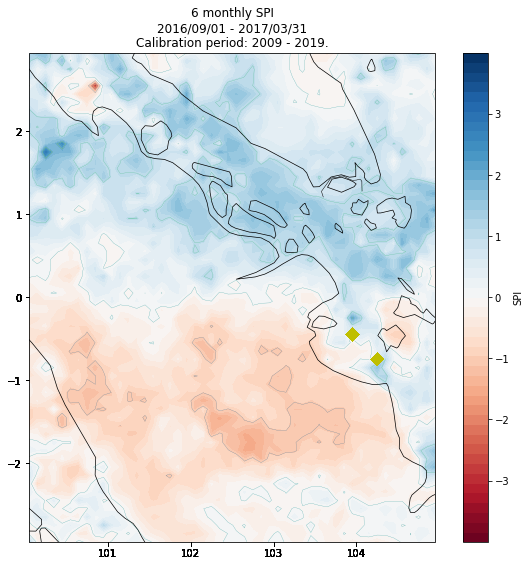

In [8]:
# Plotting the spatial distribution of SPI for calibrated area over the target dates.

target_yr, target_mth = 2017, 3 # Change accordingly for analysis.
target_day = None # leave as None if monthly SPI.

def get_spi_for_monthyear(spi, month_digit, year_4digits, 
                         calibration_year_initial=calibration_year_initial,
                         calibration_year_final=calibration_year_final,
                         periodicity=periodicity):
    yrs = calibration_year_final - calibration_year_initial
    time_intervals = yrs*periodicity.value
    yrs_idx = (year_4digits - calibration_year_initial) * 12
    yr_mth_idx = yrs_idx + month_digit - 1
#     print(yr_mth_idx)

    return spi[:, :, yr_mth_idx]

def get_date_range(yr, mth, day, timescale=timescale, periodicity=periodicity):
    format = "%Y/%m/%d"
        
    if day:
        lastday = date(yr, mth, day)
        firstday = lastday - pd.offsets.DateOffset(days=timescale)
    else:
        lastday = date(yr, mth, calendar.monthrange(yr, mth)[-1])
        firstday = date(yr, mth, 1) - pd.offsets.DateOffset(months=timescale)
    return f"{firstday.strftime(format)} - {lastday.strftime(format)}"

print(get_date_range(target_yr, target_mth, target_day))

fig = plt.Figure(figsize=(10,9))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_xticks([int(i) for i in xr_ds.lon])
ax.set_yticks([int(i) for i in xr_ds.lat])
ax.set_facecolor('y') # no data
ax.coastlines("50m", linewidth=0.7)
ax.add_feature(cf.BORDERS, linewidth=.5)
ax.set_title(f"{timescale} {periodicity.name} SPI\n"\
             f"{get_date_range(target_yr, target_mth, target_day)}\n"\
             f"Calibration period: {calibration_year_initial} - {calibration_year_final}.")

ticks= [-3, -2, -1, 0, 1, 2, 3]
ticks2 = np.linspace(-4,4,51)

contf = ax.contourf(xr_ds.lon, xr_ds.lat, 
                  get_spi_for_monthyear(spi, target_mth, target_yr), 
                  cmap='RdBu', levels=ticks2)
conts = ax.contour(contf, 'g', levels=ticks, linewidths=0.2)
fig.colorbar(contf, ticks=ticks, label='SPI')

fig